# Lone-Sum

The $n$-lone-sum problem is defined as follows: given a list of $n$ numbers, return the sum of the numbers that only occur once in the list. For example, given $1, 1, 2, 3$, a correct algorithm should return $2 + 3 = 5$.

A simple function (like the one below using only conditions) can solve the $3$-lone-sum problem.

```python
def three_lone_sum(a, b, c):
    if a == b and b == c:
        return 0
    elif a == b:
        return c
    elif b == c:
        return a
    elif c == a:
        return b
    else:
        return a + b + c 
```

In order to accept an arbitrary number of arguments, we [unpack argument lists](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists).

```python
# define with
def lone_sum(*args):
    return ...

# call with
lone_sum(1, 1, 2, 3)
# or
numbers = [1, 1, 2, 3]
lone_sum(*numbers)
```

## Setup

First, import some useful packages for generating random problems, timing algorithm runs, dealing with numbers and visualizing the results.

In [1]:
import random
import time

import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

## A Quadratic Algorithm

Below is a naive algorithm making use of  [`list.count(x)`](https://docs.python.org/3/tutorial/datastructures.html#:~:text=list.count(x)). It simply iterates through the list of numbers and for each of them, count the number of occurences and add the number only if the number appear once, exactly as the problem instructed.

In [2]:
def lone_sum1(*args):
    total = 0
    for num in args:
        if args.count(num) == 1:
            total += num

    return total

We create two functions for generating problems of size $n$:
- special problems with only interger ones
- random problems with integers randing from 0 to $n$

In [3]:
def special_problem(size=10):
    return [1] * size

In [4]:
def random_problem(size=10):
    return [random.randint(0, size) for _ in range(size)]

We do a sanity check that the functions are doing what we expect. The following code should generate one random problem instance and `lone_sum1` should be able to solve it.

In [5]:
p1 = random_problem()
p1, lone_sum1(*p1)

([3, 10, 4, 2, 10, 1, 6, 4, 0, 7], 19)

We create another function for timing an algorithm once, with specified problem function and size.

In [6]:
def time_once(algorithm, size=None, problem_function=random_problem):
    if size is None:
        problem = problem_function()
    else:
        problem = problem_function(size)
    start = time.perf_counter()
    algorithm(*problem)
    end = time.perf_counter()
    return end - start

We try this timing function on the algorithm with input size of $5000$ and both types of problems.

In [7]:
print(f"{time_once(lone_sum1, 5_000) = }")
print(f"{time_once(lone_sum1, 5_000, special_problem) = }")

time_once(lone_sum1, 5_000) = 0.14496186189353466
time_once(lone_sum1, 5_000, special_problem) = 0.0493991207331419


To my purprise, the algorithm runs much faster for the special problem instance.

We then create yet another function for plotting the running time of the algorithm against the size of input, this gives us better idea of how the algorithm scales as we encounter larger and larger problems.

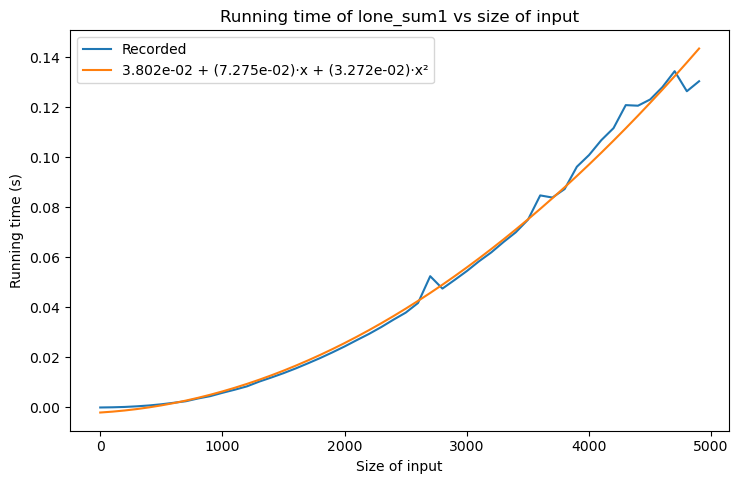

In [8]:
def plot_time_vs_size(
        algorithm,
        sizes=None,
        problem_function=random_problem,
        polyfit_deg=None):
    if sizes is None:
        sizes = np.arange(1, 5_000, 100)
    times = np.vectorize(lambda size: time_once(algorithm, size, problem_function))(sizes)
    plt.figure(figsize=(8.5, 5.2))
    plt.plot(sizes, times, label="Recorded")
    plt.title(f"Running time of {algorithm.__name__} vs size of input")
    plt.xlabel("Size of input")
    plt.ylabel("Running time (s)")
    if polyfit_deg is not None:
        polynomial = Polynomial.fit(sizes, times, polyfit_deg)
        plt.plot(sizes, polynomial(sizes), label=str(polynomial))
        plt.legend()

plot_time_vs_size(lone_sum1, polyfit_deg=2)
plt.show()

We can see that the algorithnm is roughly quadratic. It makes sense because we are iterating through all elements, that means there are $\mathcal O(n)$ iterations. In each iteration, we also run `list.count()` which is roughly equivalent to the following:

```python
# args.count(num)
count = 0
for item in args:
    if item == num:
        count += 1
# return count
```

That is another loop that iterates through the entire list within the loop `for num in args`. So, the algorithm runs in $\mathcal O(n^2)$ overall.

_Note that the graph is in no way a rigorous way of assessing performance of algorithms, it's more of an intuition. Sometimes you'll see huge bumps in the graph. Run the code again for a few times and you may get more meaningful results._

## A Potentially Log-Linear Algorithm

A quicker algorithm that I can think of:

- First, sort the numbers.
- Then, loop through the numbers and keep count of whether the number is seen. If the number is seen, then we increment the count; Otherwise, the count is the number of times the integer last seen occurs in the list. If the count is 1, we add the number last seen to the total.

In [9]:
def lone_sum2(*args):
    args = sorted(args)
    total = 0  # result
    last = None  # the number last seen
    count = 0  # the count of the number last seen
    for num in args:
        if num == last:
            count += 1
        else:
            if count == 1:
                total += last
            # reset number last seen and count
            last, count = num, 1
    if count == 1:
        total += last
    return total

We do a sanity check by comparing the result of this new algorithm to the one before.

In [10]:
problem = random_problem()
print(f"{problem = }\n{lone_sum2(*problem) = }")
assert lone_sum1(*problem) == lone_sum2(*problem)

problem = [8, 1, 7, 10, 6, 3, 3, 2, 10, 8]
lone_sum2(*problem) = 16


We plot the running time of this new algorithm against the size of input.

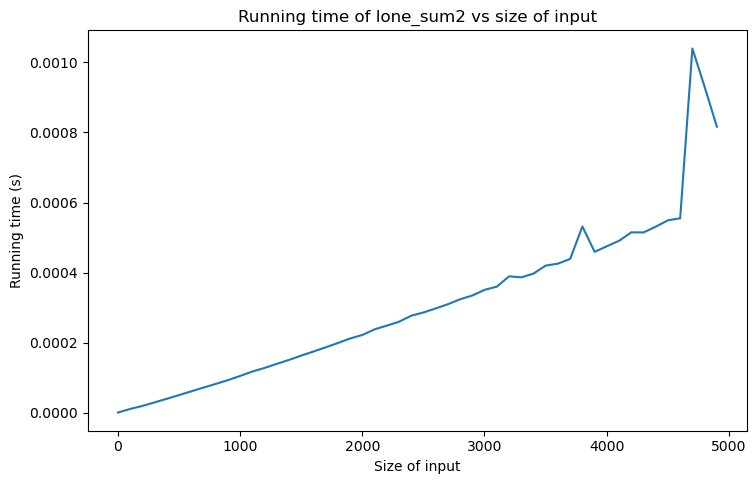

In [11]:
plot_time_vs_size(lone_sum2)
plt.show()

We get a few "unlucky" rolls - represented by the spikes, but The running time seems to increase at lesser rate than before.

In [12]:
time_once(lone_sum2, size=5_000) / time_once(lone_sum1, size=5_000)

0.003864266186903059

The result varies on different machines, but on my machine for a problem of size $5000$ the running time of the new algorithm spent less than $1\%$ of the running time of the previous algorithm.

_Theoretically, this algorithm runs in $\mathcal O(n\log n)$ time in the worst case. Most of the heavy lifting is done in `sorted`, which [runs in $\mathcal O(n\log n)$ for `list`](https://wiki.python.org/moin/TimeComplexity). The rest is just a loop iterating through all items in the list with basic arithmatics and conditionals (constant time $\mathcal O(1)$ operations), which runs in $\mathcal O(n)$._

## The Same Algorithm but One-liner

The log-linear algorithm is essentially counting the number of times each number occurs in the list. Python standard library has a class just for that - [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter). When given an iterable of elements (numbers),

> It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values

We also make use of [generator expression](https://peps.python.org/pep-0289/). With the two new tools equipped, we can shorten the previous code to just one line, and it performs just as good as before.

problem = [6, 0, 7, 3, 7, 8, 4, 2, 7, 1]
lone_sum3(*problem) = 24


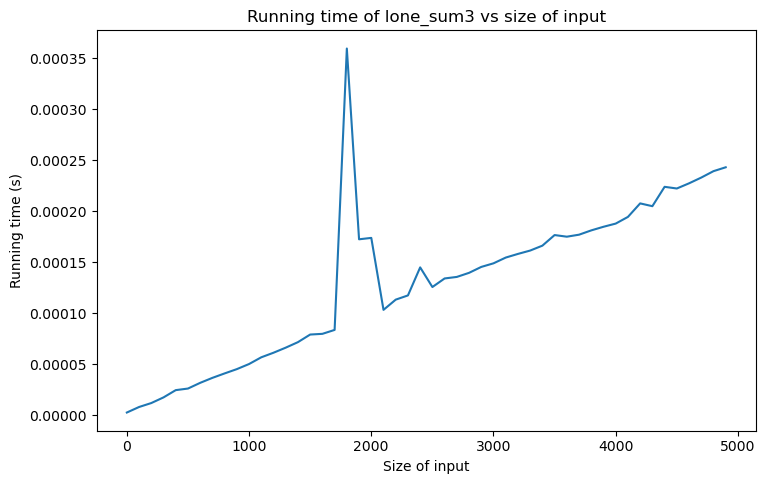

In [13]:
from collections import Counter

def lone_sum3(*args):
    return sum(num for num, count in Counter(args).items() if count == 1)

problem = random_problem()
print(f"{problem = }\n{lone_sum3(*problem) = }")
assert lone_sum1(*problem) == lone_sum3(*problem)

plot_time_vs_size(lone_sum3)
plt.show()